In [1]:
!pip install --upgrade pip
!pip install tensorflow

^C
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/bin/pip", line 11, in <module>
    sys.exit(main())
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pip/_internal/cli/main.py", line 73, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pip/_internal/commands/__init__.py", line 96, in create_command
    module = importlib.import_module(module_path)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._b

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

import tensorflow as tf
keras = tf.keras


In [118]:
caiso = pd.read_csv('data/caiso_master.csv')
caiso.drop('Unnamed: 0', axis=1, inplace=True)
caiso['INTERVAL_START_PT'] = pd.to_datetime(caiso['INTERVAL_START_PT']).apply(lambda x: x.replace(tzinfo=None))
caiso['INTERVAL_END_PT'] = pd.to_datetime(caiso['INTERVAL_END_PT']).apply(lambda x: x.replace(tzinfo=None))
caiso['date_hour_start'] = pd.to_datetime(caiso['date_hour_start']).apply(lambda x: x.replace(tzinfo=None))
caiso['OPR_DT_PT'] = pd.to_datetime(caiso['OPR_DT_PT']).apply(lambda x: x.replace(tzinfo=None))

caiso.set_index('INTERVAL_START_PT', inplace=True)

caiso.rename({'HH_$_million_BTU_not_seasonal_adj': 'HH_$_mill_BTU', 'total_mw':'total_gen'},axis=1, inplace=True)
caiso['HH_$_mill_BTU'] = pd.to_numeric(caiso['HH_$_mill_BTU'])

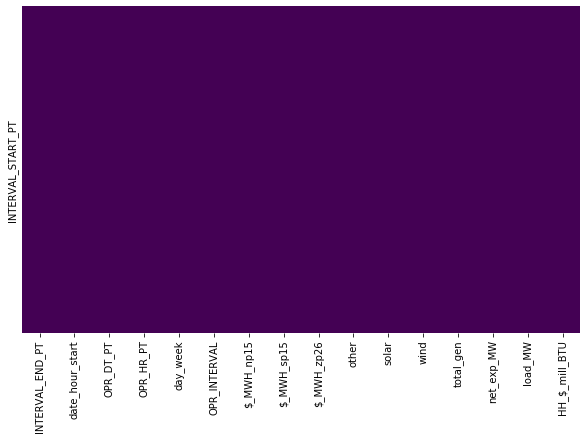

In [119]:
plt.figure(figsize=(10,6))
sns.heatmap(caiso.isnull(), yticklabels=False, cbar=False, cmap='viridis')

---
# Data Processing

In [84]:
one_week_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-05-24'])
two_week_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-05-17'])
one_month_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-05-01'])
two_month_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-04-01'])

trn_tst_splt = one_week_idx
train_df = caiso.iloc[:trn_tst_splt, :]
test_df = caiso.iloc[trn_tst_splt:, :]

# Train set
np15_lmp_train = train_df['$_MWH_np15'].values
sp15_lmp_train = train_df['$_MWH_sp15'].values
zp26_lmp_train = train_df['$_MWH_zp26'].values
exog_train = train_df[['day_week', 'other', 'solar', 'wind', 'total_gen', 'net_exp_MW','load_MW', 'HH_$_mill_BTU']].values
train_dates = train_df.index.to_period('H')

# test set
np15_lmp_test = test_df['$_MWH_np15'].values
sp15_lmp_test = test_df['$_MWH_sp15'].values
zp26_lmp_test = test_df['$_MWH_zp26'].values
exog_test = test_df[['day_week', 'other', 'solar', 'wind','total_gen', 'net_exp_MW','load_MW', 'HH_$_mill_BTU']].values
test_dates = test_df.index.to_period('H')

n_period_fcst = len(test_dates)

# Use lists:
all_train_lmp = [np15_lmp_train, sp15_lmp_train, zp26_lmp_train]
all_test_lmp = [np15_lmp_test, sp15_lmp_test, zp26_lmp_test]

allocation_check = len(train_df) + len(test_df) == len(caiso)
print("Dataset allocation check: ", allocation_check)

Dataset allocation check:  True


In [120]:
len(caiso)

11519

---
# LSTM

Gating allows the net decide when to remember the current input and forget it for future inputs. 

The way Keras LSTM layers work is by taking in a numpy array of 3 dimensions (N, W, F) where N is the number of training sequences, W is the sequence length and F is the number of features of each sequence. I chose to go with a sequence length (read window size) of 50 which allows for the network so get glimpses of the shape of the sin wave at each sequence and hence will hopefully teach itself to build up a pattern of the sequences based on the prior window received.

In [144]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

def split_and_windowize(data, n_prev, fraction_test=0.3):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

def calc_rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

In [147]:
np_lmp_arr = caiso['$_MWH_np15'].values
sp_lmp_arr = caiso['$_MWH_sp15'].values
zp_lmp_arr = caiso['$_MWH_zp26'].values
datetime_arr = caiso.index

In [127]:
dataset = caiso['$_MWH_np15'].values

# Determines window
batch_size = 24 * 7
train_test_allocation = batch_size / len(dataset)

X1_train, X1_test, y1_train, y1_test = split_and_windowize(dataset, batch_size, train_test_allocation)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((10852, 168, 1), (331, 168, 1), (10852,), (331,))

In [165]:
n_features = X1_train.shape[2]

# return_sequence must equal True for insider layers b/c they provided feedback to the network.
lstm_endo = keras.Sequential()
lstm_endo.add(keras.layers.LSTM(32, input_shape=(batch_size, n_features), return_sequences=True))
lstm_endo.add(keras.layers.LSTM(32, return_sequences=True))
lstm_endo.add(keras.layers.LSTM(32, return_sequences=False))
lstm_endo.add(keras.layers.Dense(1, activation='linear'))
lstm_endo.compile(optimizer='adam',loss='mse')
lstm_endo.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 168, 32)           4352      
_________________________________________________________________
lstm_31 (LSTM)               (None, 168, 32)           8320      
_________________________________________________________________
lstm_32 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [166]:
lstm_endo.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 168, 32)           4352      
_________________________________________________________________
lstm_31 (LSTM)               (None, 168, 32)           8320      
_________________________________________________________________
lstm_32 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_endo.fit(X1_train, y1_train, batch_size, epochs=20)

Epoch 1/20
65/65 [==============================] - 15s 238ms/step - loss: 1311.7616
Epoch 2/20
65/65 [==============================] - 15s 237ms/step - loss: 1037.6981
Epoch 3/20
65/65 [==============================] - 15s 237ms/step - loss: 924.6244
Epoch 4/20
65/65 [==============================] - 15s 237ms/step - loss: 836.2482
Epoch 5/20
65/65 [==============================] - 15s 237ms/step - loss: 763.3629
Epoch 6/20
65/65 [==============================] - 16s 239ms/step - loss: 697.0037
Epoch 7/20
65/65 [==============================] - 15s 236ms/step - loss: 638.6898
Epoch 8/20
65/65 [==============================] - 15s 236ms/step - loss: 589.2572
Epoch 9/20
65/65 [==============================] - 15s 236ms/step - loss: 547.2219
Epoch 10/20
65/65 [==============================] - 15s 236ms/step - loss: 511.1219
Epoch 11/20
65/65 [==============================] - 15s 237ms/step - loss: 480.0270
Epoch 12/20
65/65 [==============================] - 15s 236ms/step - lo

In [164]:
y1_pred = lstm_endo.predict(X1_test)
np_rmse_endo = calc_rmse(y1_test, y1_pred)
print("RMSE - NP15 LSTM - Endo {:.5}".format(np_rmse_endo))



RMSE - NP15 LSTM - Endo 13.308


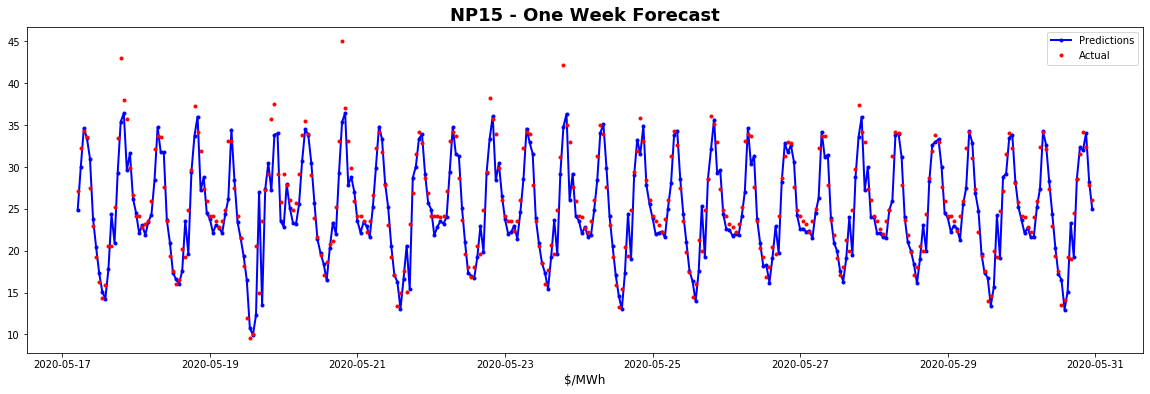

In [156]:
fig, ax = plt.subplots(figsize=(20,6))
dt = -len(y1_test)

ax.plot(datetime_arr[dt:], y1_pred, 'b.-', label='Predictions', lw=2)
ax.plot(datetime_arr[dt:], y1_test, 'r.', label='Actual')
ax.set_title('NP15 - One Week Forecast', fontsize=18, fontweight='bold')
ax.set_xlabel('$/MWh', fontsize=12)
ax.legend();

In [153]:
datetime_arr[-100:]

DatetimeIndex(['2020-05-26 20:00:00', '2020-05-26 21:00:00',
               '2020-05-26 22:00:00', '2020-05-26 23:00:00',
               '2020-05-27 00:00:00', '2020-05-27 01:00:00',
               '2020-05-27 02:00:00', '2020-05-27 03:00:00',
               '2020-05-27 04:00:00', '2020-05-27 05:00:00',
               '2020-05-27 06:00:00', '2020-05-27 07:00:00',
               '2020-05-27 08:00:00', '2020-05-27 09:00:00',
               '2020-05-27 10:00:00', '2020-05-27 11:00:00',
               '2020-05-27 12:00:00', '2020-05-27 13:00:00',
               '2020-05-27 14:00:00', '2020-05-27 15:00:00',
               '2020-05-27 16:00:00', '2020-05-27 17:00:00',
               '2020-05-27 18:00:00', '2020-05-27 19:00:00',
               '2020-05-27 20:00:00', '2020-05-27 21:00:00',
               '2020-05-27 22:00:00', '2020-05-27 23:00:00',
               '2020-05-28 00:00:00', '2020-05-28 01:00:00',
               '2020-05-28 02:00:00', '2020-05-28 03:00:00',
               '2020-05-

---
## SP15 Endogenous